In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    matthews_corrcoef, balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay
)

### 1) Read data from the given file. 


In [23]:
df = pd.read_csv("data/data.csv", delimiter=';')

### 2) Determine and display the number of records and display the attributes of the dataset.

In [24]:
df.shape

(1599, 12)

In [25]:
df.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

### 3) Get ten options for shuffling the data set and splitting it into training and test sets using the ShuffleSplit function. Generate the initial and test sets based on the eighth option. Find out if the data set is balanced.

In [26]:
random_state = 1
splits = list(ShuffleSplit(n_splits=10, test_size=1/3, random_state=random_state).split(df))

df_train = df.iloc[splits[7][0]]
df_test = df.iloc[splits[7][1]]

In [27]:
print("Classes balance (training set):")
print(df_train['quality'].value_counts())

print("\nClasses balance (test set):")
print(df_test['quality'].value_counts())

Classes balance (training set):
quality
5    466
6    415
7    129
4     34
8     14
3      8
Name: count, dtype: int64

Classes balance (test set):
quality
6    223
5    215
7     70
4     19
8      4
3      2
Name: count, dtype: int64


#### We can see that the data is very unbalanced. Most examples are with classes 5 and 6, and the rare classes (3, 4, 8) have very few elements.

### 4) Using the KNeighborsClassifier function of the scikit-learn library, build a classification model based on the k-nearest neighbors method (leave all parameter values ​​at default) and train it on the training set.


In [28]:
x_train = df_train.drop('quality', axis=1)
y_train= df_train['quality']

x_test = df_test.drop('quality', axis=1)
y_test= df_test['quality']

In [29]:
model = KNeighborsClassifier()
model.fit(x_train, y_train)

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


### 5) Calculate the classification metrics of the built model for the training and test sets. Present the results of the model on the test set graphically.

In [30]:
def metrics_calc_display(actual, predicted):
    """ Function for calculating and displaying all necessary metrics """
    print(f"Accuracy: {accuracy_score(actual, predicted)}")
    print(f"Precision: {precision_score(actual, predicted, zero_division=0, average='weighted')}")
    print(f"Recall: {recall_score(actual, predicted, average='weighted')}")
    print(f"F1-score (weighted): {f1_score(actual, predicted, average='weighted')}")
    print(f"F1-score (macro): {f1_score(actual, predicted, average='macro')}")
    print(f"MCC: {matthews_corrcoef(actual, predicted)}")
    print(f"Balanced accuracy: {balanced_accuracy_score(actual, predicted)}")

In [31]:
# Training set
prediction_train = model.predict(x_train)
print("\nMetrics for the training sample:")
metrics_calc_display(y_train, prediction_train)


Metrics for the training sample:
Accuracy: 0.6435272045028143
Precision: 0.6306753234826643
Recall: 0.6435272045028143
F1-score (weighted): 0.6252665290897911
F1-score (macro): 0.345030967613557
MCC: 0.41994876037835577
Balanced accuracy: 0.328839225866161


In [32]:
# Test set
prediction_test = model.predict(x_test)
print("\nMetrics for the test sample:")
metrics_calc_display(y_test, prediction_test)


Metrics for the test sample:
Accuracy: 0.474671669793621
Precision: 0.4474377465840019
Recall: 0.474671669793621
F1-score (weighted): 0.4541486723858101
F1-score (macro): 0.21421765001729542
MCC: 0.1450213633637155
Balanced accuracy: 0.21579587722042615


#### The default value of the number of neighbors for KNeighborsClassifier is 5. We see that on the test sample the model gives significantly worse results, and metrics that take into account class imbalance (MCC, Balanced accuracy, F1-score (macro)) generally have much worse performance, which indicates very poor recognition of small classes.

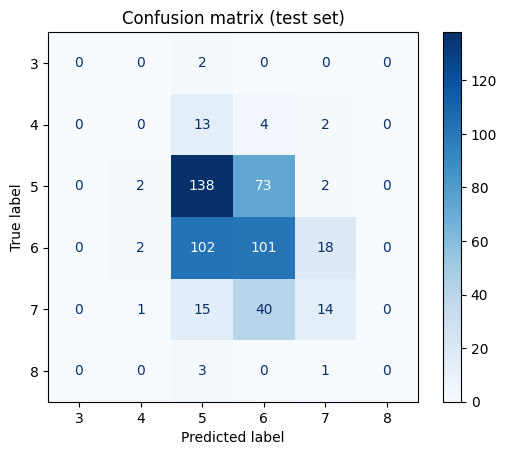

In [33]:
# Confusion matrix for test set
cm = confusion_matrix(y_test, prediction_test, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion matrix (test set)")
plt.show()

### 6) Find out the effect of the number of neighbors (from 1 to 20) on the classification results. Present the results graphically.


In [34]:
check_n_neighbors = {'n_neighbors': [], 'f1_score_train': [], 'f1_score_test': []}
for i in range(1, 21):
    model = KNeighborsClassifier(n_neighbors=i)
    model.fit(x_train, y_train)

    prediction_train = model.predict(x_train)
    f1_score_train = f1_score(y_train, prediction_train, average='macro')
    
    prediction_test = model.predict(x_test)
    f1_score_test = f1_score(y_test, prediction_test, average='macro')

    check_n_neighbors['n_neighbors'].append(i)
    check_n_neighbors['f1_score_train'].append(f1_score_train)
    check_n_neighbors['f1_score_test'].append(f1_score_test)

check_n_neighbors = pd.DataFrame(check_n_neighbors)

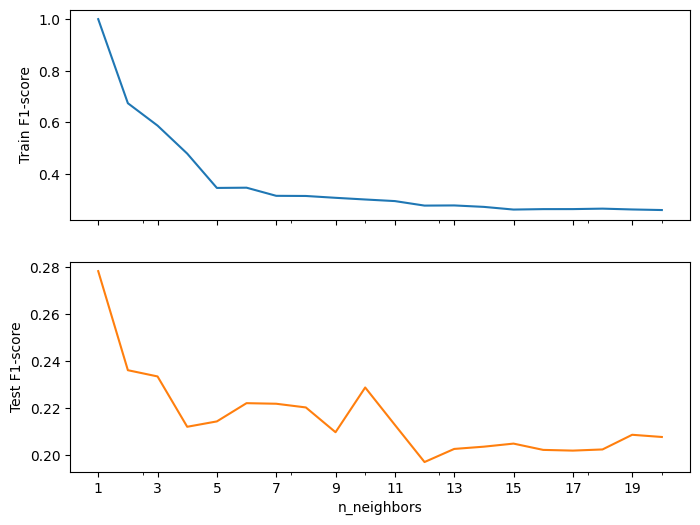

In [35]:
axes = check_n_neighbors.plot(figsize=(8, 6), subplots=True, x='n_neighbors', layout=(2,1), xticks=range(1, 20, 2), legend=False)
axes[0][0].set_ylabel("Train F1-score")
axes[1][0].set_ylabel("Test F1-score")
axes[1][0].set_xlabel("n_neighbors")
plt.show()

#### As the number of neighbors increases, the F1-score for the training set drops, as the model starts to consider more neighbors from dominant classes, reducing the accuracy of predicting rare classes. Interestingly, the best result for the test set is also achieved with a number of neighbors of 1. This may be because most of the points in the test belong to large classes (5, 6, 7), and KNN with k=1 actually uses only the nearest neighbor, so some classes are not “swallowed” by the neighbors of large classes.

In [36]:
model = KNeighborsClassifier(n_neighbors=1)
model.fit(x_train, y_train)

# Test set
prediction_test = model.predict(x_test)
print("\nMetrics for the test set:")
metrics_calc_display(y_test, prediction_test)


Metrics for the test set:
Accuracy: 0.5459662288930581
Precision: 0.5380864261458319
Recall: 0.5459662288930581
F1-score (weighted): 0.540010322271963
F1-score (macro): 0.2781188508461236
MCC: 0.27857342680638436
Balanced accuracy: 0.27176822021682634


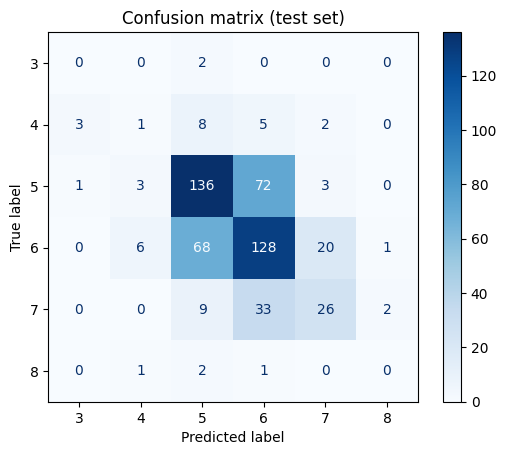

In [37]:
# Confusion matrix for test set
cm = confusion_matrix(y_test, prediction_test, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion matrix (test set)")
plt.show()